In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("../../data/quarterly_data.csv", encoding = 'unicode_escape')

In [15]:
df1 = df.replace("..", np.nan)

In [16]:
df1

,Postal code,Building type,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",5458,5347,5826,5566,5545,5812,5909,5856,...,7755,8332,8130,8068,7802,8543,9170,7517,8872,8596
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",5164,5021,5081,5006,5713,5866,5552,5614,...,6914,7694,6901,7435,7573,7398,7868,7700,7829,7974
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",4944,5396,4828,5394,5571,5709,5450,5010,...,6883,6846,7379,6728,7205,6678,7178,7405,8053,8174
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,5168,5219,5181,5269,5632,5807,5630,5511,...,7043,7478,7476,7345,7460,7275,8058,7540,8188,8188
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, two-room flat",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10070,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, three-room flat+",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10071,99980 Utsjoki Keskus (Utsjoki ),Blocks of flats total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10072,99980 Utsjoki Keskus (Utsjoki ),Terraced houses total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# original source https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
# summarize the number of rows with missing values for each column
for i in range(df1.shape[1]):
    n_miss = df1.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 8466 (84.0%)
> 3, Missing: 8371 (83.1%)
> 4, Missing: 8437 (83.8%)
> 5, Missing: 8470 (84.1%)
> 6, Missing: 8429 (83.7%)
> 7, Missing: 8383 (83.2%)
> 8, Missing: 8401 (83.4%)
> 9, Missing: 8676 (86.1%)
> 10, Missing: 8517 (84.5%)
> 11, Missing: 8388 (83.3%)
> 12, Missing: 7979 (79.2%)
> 13, Missing: 8071 (80.1%)
> 14, Missing: 8538 (84.8%)
> 15, Missing: 8544 (84.8%)
> 16, Missing: 8596 (85.3%)
> 17, Missing: 8736 (86.7%)
> 18, Missing: 8683 (86.2%)
> 19, Missing: 8637 (85.7%)
> 20, Missing: 8653 (85.9%)
> 21, Missing: 8760 (87.0%)
> 22, Missing: 8687 (86.2%)
> 23, Missing: 8612 (85.5%)
> 24, Missing: 8579 (85.2%)
> 25, Missing: 8677 (86.1%)
> 26, Missing: 8747 (86.8%)
> 27, Missing: 8551 (84.9%)
> 28, Missing: 8647 (85.8%)
> 29, Missing: 8769 (87.0%)
> 30, Missing: 8640 (85.8%)
> 31, Missing: 8682 (86.2%)
> 32, Missing: 8575 (85.1%)
> 33, Missing: 8739 (86.7%)
> 34, Missing: 8721 (86.6%)
> 35, Missing: 8655 (85.9%)
> 36, Miss

In [18]:
## Categories and numerical features to different dfs

cat = df1.iloc[:,0:2]
num = df1.iloc[:,2:]
num_columns = num.columns

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
num_imp = imp.fit_transform(num)

/Users/kenriippa/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [20]:
df_num_imp = pd.DataFrame(num_imp, columns=num_columns)
df_num_imp

,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),2012Q1 Price per square meter (EUR/m2),2012Q2 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,5458.000000,5347.000000,5826.000000,5566.000000,5545.000000,5812.000000,5909.000000,5856.000000,5785.000000,6436.000000,...,7755.000000,8332.000000,8130.000000,8068.0000,7802.000000,8543.000000,9170.000000,7517.000000,8872.000000,8596.000000
1,5164.000000,5021.000000,5081.000000,5006.000000,5713.000000,5866.000000,5552.000000,5614.000000,6020.000000,5814.000000,...,6914.000000,7694.000000,6901.000000,7435.0000,7573.000000,7398.000000,7868.000000,7700.000000,7829.000000,7974.000000
2,4944.000000,5396.000000,4828.000000,5394.000000,5571.000000,5709.000000,5450.000000,5010.000000,5704.000000,5466.000000,...,6883.000000,6846.000000,7379.000000,6728.0000,7205.000000,6678.000000,7178.000000,7405.000000,8053.000000,8174.000000
3,5168.000000,5219.000000,5181.000000,5269.000000,5632.000000,5807.000000,5630.000000,5511.000000,5843.000000,5899.000000,...,7043.000000,7478.000000,7476.000000,7345.0000,7460.000000,7275.000000,8058.000000,7540.000000,8188.000000,8188.000000
4,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10070,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10071,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10072,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173


In [21]:
df_num_imp.isnull().sum()

2010Q1 Price per square meter (EUR/m2)     0
2010Q2 Price per square meter (EUR/m2)     0
2010Q3 Price per square meter (EUR/m2)     0
2010Q4 Price per square meter (EUR/m2)     0
2011Q1 Price per square meter (EUR/m2)     0
2011Q2 Price per square meter (EUR/m2)     0
2011Q3 Price per square meter (EUR/m2)     0
2011Q4 Price per square meter (EUR/m2)     0
2012Q1 Price per square meter (EUR/m2)     0
2012Q2 Price per square meter (EUR/m2)     0
2012Q3 Price per square meter (EUR/m2)     0
2012Q4 Price per square meter (EUR/m2)     0
2013Q1 Price per square meter (EUR/m2)     0
2013Q2 Price per square meter (EUR/m2)     0
2013Q3 Price per square meter (EUR/m2)     0
2013Q4 Price per square meter (EUR/m2)     0
2014Q1 Price per square meter (EUR/m2)     0
2014Q2 Price per square meter (EUR/m2)     0
2014Q3 Price per square meter (EUR/m2)     0
2014Q4 Price per square meter (EUR/m2)     0
2015Q1 Price per square meter (EUR/m2)     0
2015Q2 Price per square meter (EUR/m2)     0
2015Q3 Pri

In [22]:
df_imp = pd.concat([cat, df_num_imp],axis=1)

In [23]:
df_imp.head()

,Postal code,Building type,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",5458.000000,5347.000000,5826.000000,5566.000000,5545.000000,5812.000000,5909.000000,5856.000000,...,7755.000000,8332.000000,8130.000000,8068.0000,7802.000000,8543.000000,9170.000000,7517.000000,8872.000000,8596.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",5164.000000,5021.000000,5081.000000,5006.000000,5713.000000,5866.000000,5552.000000,5614.000000,...,6914.000000,7694.000000,6901.000000,7435.0000,7573.000000,7398.000000,7868.000000,7700.000000,7829.000000,7974.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",4944.000000,5396.000000,4828.000000,5394.000000,5571.000000,5709.000000,5450.000000,5010.000000,...,6883.000000,6846.000000,7379.000000,6728.0000,7205.000000,6678.000000,7178.000000,7405.000000,8053.000000,8174.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,5168.000000,5219.000000,5181.000000,5269.000000,5632.000000,5807.000000,5630.000000,5511.000000,...,7043.000000,7478.000000,7476.000000,7345.0000,7460.000000,7275.000000,8058.000000,7540.000000,8188.000000,8188.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173


In [24]:
df4 = df_imp.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")

In [25]:
df4.loc[df4["Postal code"] == "00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )"]

,Postal code,Building type,Quarter,EUR/m2
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",2010Q1 Price per square meter (EUR/m2),5458.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2010Q1 Price per square meter (EUR/m2),5164.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2010Q1 Price per square meter (EUR/m2),4944.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2010Q1 Price per square meter (EUR/m2),5168.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2010Q1 Price per square meter (EUR/m2),1783.222523
...,...,...,...,...
453331,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2021Q2* Price per square meter (EUR/m2),7974.000000
453332,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2021Q2* Price per square meter (EUR/m2),8174.000000
453333,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2021Q2* Price per square meter (EUR/m2),8188.000000
453334,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2021Q2* Price per square meter (EUR/m2),2290.004173


In [26]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"4/1", "Q3":"7/1", "Q4":"10/1"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df4["Quarter"] = df4["Quarter"].apply(lambda row: quarter_to_datetime(row))
df4

,Postal code,Building type,Quarter,EUR/m2
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",2010-01-01,5458.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2010-01-01,5164.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2010-01-01,4944.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2010-01-01,5168.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2010-01-01,1783.222523
...,...,...,...,...
463399,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, two-room flat",2021-01-04,2290.004173
463400,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, three-room flat+",2021-01-04,2290.004173
463401,99980 Utsjoki Keskus (Utsjoki ),Blocks of flats total,2021-01-04,2290.004173
463402,99980 Utsjoki Keskus (Utsjoki ),Terraced houses total,2021-01-04,2290.004173


In [27]:
### Split postal code and place

df4[['Postal code', 'Location']] = df4['Postal code'].str.split(' ', 1, expand=True)
df4

,Postal code,Building type,Quarter,EUR/m2,Location
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
3,00100,Blocks of flats total,2010-01-01,5168.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
4,00100,Terraced houses total,2010-01-01,1783.222523,Helsinki Keskusta - Etu-Töölö (Helsinki )
...,...,...,...,...,...
463399,99980,"Blocks of flats, two-room flat",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )
463400,99980,"Blocks of flats, three-room flat+",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )
463401,99980,Blocks of flats total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )
463402,99980,Terraced houses total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki )


In [28]:
import pgeocode
import time

In [29]:
"""def postal_code_to_geolocation(row):
    nomi = pgeocode.Nominatim('fi')
    location = nomi.query_postal_code(postal_code)
    return location.latitude, location.longitude"""

"def postal_code_to_geolocation(row):\n    nomi = pgeocode.Nominatim('fi')\n    location = nomi.query_postal_code(postal_code)\n    return location.latitude, location.longitude"

In [30]:
"""geolocation_dic = {}

latitude, longitude = postal_code_to_geolocation()
print(latitude)
geolocation_dic[p] = (latitude, longitude)
time.sleep(10)"""

'geolocation_dic = {}\n\nlatitude, longitude = postal_code_to_geolocation()\nprint(latitude)\ngeolocation_dic[p] = (latitude, longitude)\ntime.sleep(10)'

In [31]:
postal_code_list = list(df4["Postal code"].unique())
nomi = pgeocode.Nominatim('fi')
location = nomi.query_postal_code(postal_code_list)

In [32]:
location

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,00100,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1714,24.9316,6.0
1,00120,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1632,24.9391,6.0
2,00130,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1645,24.9487,6.0
3,00140,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1578,24.9525,6.0
4,00150,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1570,24.9369,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1674,99830,FI,Saariselkä,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.4230,27.3965,6.0
1675,99870,FI,Inari,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.9287,26.9896,6.0
1676,99930,FI,Sevettijärvi,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,69.4918,28.5786,4.0
1677,99950,FI,Karigasniemi,Lapland,19.0,Pohjois-Lappi,197.0,Utsjoki,890.0,69.4729,25.9527,4.0


In [33]:
cond = location['latitude'].isna()
jalla = location.assign(cond1= cond)
jalla

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy,cond1
0,00100,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1714,24.9316,6.0,False
1,00120,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1632,24.9391,6.0,False
2,00130,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1645,24.9487,6.0,False
3,00140,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1578,24.9525,6.0,False
4,00150,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1570,24.9369,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,99830,FI,Saariselkä,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.4230,27.3965,6.0,False
1675,99870,FI,Inari,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.9287,26.9896,6.0,False
1676,99930,FI,Sevettijärvi,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,69.4918,28.5786,4.0,False
1677,99950,FI,Karigasniemi,Lapland,19.0,Pohjois-Lappi,197.0,Utsjoki,890.0,69.4729,25.9527,4.0,False


In [34]:
## Find rows which are empty
# Source https://www.kite.com/python/answers/how-to-find-rows-with-nan-values-in-a-pandas-dataframe-in-python


is_NaN = location.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = location[row_has_NaN]
rows_with_NaN

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
37,00540,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1841,24.9785,NaN
289,08450,FI,Lohja,Uusimaa,1.0,Helsinki,11.0,Lohja,444.0,60.2713,23.9952,NaN
294,09120,FI,Karjalohja,Uusimaa,1.0,Helsinki,11.0,Lohja,444.0,60.2506,23.7101,NaN
307,10440,FI,Bollsta,Uusimaa,1.0,Raaseporin,14.0,Raseborg,710.0,60.1126,23.5225,NaN
317,10710,FI,Snappertuna,Uusimaa,1.0,Raaseporin,14.0,Raseborg,710.0,59.9782,23.7238,NaN
440,20100,FI,Turku,Southwest Finland,2.0,Turku,23.0,Turku,853.0,60.4449,22.2261,NaN
565,25650,FI,Strömma,Southwest Finland,2.0,Åboland-Turunmaa,21.0,Kimitoön,322.0,60.1888,22.8499,NaN
576,26410,FI,Kaaro,Satakunta,4.0,Rauma,41.0,Rauma,684.0,61.1767,21.5183,NaN
852,41350,FI,Laukaa As,Central Finland Region,13.0,Jyväskylä,131.0,Laukaa,410.0,62.4267,25.8850,NaN
859,41530,FI,Veneranta,Central Finland Region,13.0,Jyväskylä,131.0,Hankasalmi,77.0,62.3759,26.3465,NaN


In [35]:
###. WORK IN PROGRESS (93999 FOR KUUSAMO)
# THIS HAS TO BE ADDED MANUALLY

wanted_features_location = location[["postal_code", 
                                     "place_name", 
                                     "state_name", 
                                     "county_name", 
                                     "latitude", 
                                     "longitude"]]
wanted_features_location = wanted_features_location.rename(columns={"postal_code": "Postal code"})

In [36]:
df_merge = pd.merge(df4, wanted_features_location, on="Postal code")

In [37]:
df_merge

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
3,00100,Blocks of flats total,2010-01-01,5168.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
4,00100,Terraced houses total,2010-01-01,1783.222523,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
...,...,...,...,...,...,...,...,...,...,...
463399,99980,"Blocks of flats, two-room flat",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463400,99980,"Blocks of flats, three-room flat+",2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463401,99980,Blocks of flats total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463402,99980,Terraced houses total,2021-01-04,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907


In [38]:
#Some columns are missing their geolocation features :(

for i in range(df_merge.shape[1]):
    n_miss = df_merge.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 0 (0.0%)
> 4, Missing: 0 (0.0%)
> 5, Missing: 276 (2.7%)
> 6, Missing: 276 (2.7%)
> 7, Missing: 276 (2.7%)
> 8, Missing: 276 (2.7%)
> 9, Missing: 276 (2.7%)


## Value of square meter of cities Q2 2021

In [39]:
Q2_2021__one_room = df_merge[(df_merge["Quarter"] == "2021-01-04") & (df_merge["Building type"] == "Blocks of flats, one-room flat")]


In [40]:
Q2_2021__one_room

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
270,00100,"Blocks of flats, one-room flat",2021-01-04,8596.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
546,00120,"Blocks of flats, one-room flat",2021-01-04,8549.699924,Punavuori (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1632,24.9391
822,00130,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Kaartinkaupunki (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1645,24.9487
1098,00140,"Blocks of flats, one-room flat",2021-01-04,10025.116718,Kaivopuisto - Ullanlinna (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1578,24.9525
1374,00150,"Blocks of flats, one-room flat",2021-01-04,9420.000000,Eira - Hernesaari (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1570,24.9369
...,...,...,...,...,...,...,...,...,...,...
462294,99830,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Saariselkä (Inari ),Saariselkä,Lapland,Pohjois-Lappi,68.4230,27.3965
462570,99870,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Inari Keskus-Lemmenjoki (Inari ),Inari,Lapland,Pohjois-Lappi,68.9287,26.9896
462846,99930,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Sevettijärvi-Näätämö (Inari ),Sevettijärvi,Lapland,Pohjois-Lappi,69.4918,28.5786
463122,99950,"Blocks of flats, one-room flat",2021-01-04,2290.004173,Karigasniemi (Utsjoki ),Karigasniemi,Lapland,Pohjois-Lappi,69.4729,25.9527


No handles with labels found to put in legend.


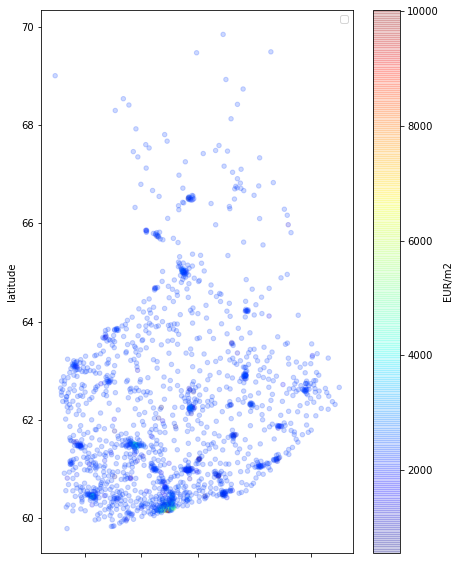

In [41]:
Q2_2021__one_room.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### Only Helsinki

No handles with labels found to put in legend.


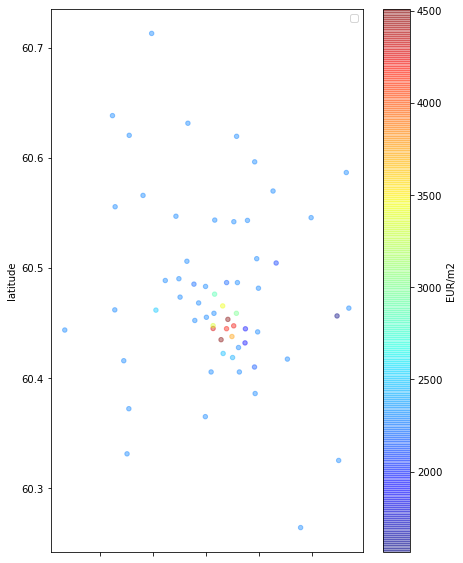

In [52]:
helsinki_df = Q2_2021__one_room[Q2_2021__one_room["county_name"] == "Helsink"]

helsinki_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [51]:
helsinki_df.sort_values(by="EUR/m2", ascending=False).head()

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
1098,00140,"Blocks of flats, one-room flat",2021-01-04,10025.116718,Kaivopuisto - Ullanlinna (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1578,24.9525
1374,00150,"Blocks of flats, one-room flat",2021-01-04,9420.000000,Eira - Hernesaari (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1570,24.9369
1650,00160,"Blocks of flats, one-room flat",2021-01-04,8874.728222,Katajanokka (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1671,24.9684
2202,00180,"Blocks of flats, one-room flat",2021-01-04,8684.000000,Kamppi - Ruoholahti (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1634,24.9190
270,00100,"Blocks of flats, one-room flat",2021-01-04,8596.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
